In [1]:
import pandas as pd

from octopus.db import PostgresqlManager
from dotenv import load_dotenv

import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

import numpy as np

from datetime import datetime
from tqdm import tqdm
import seaborn as sns


In [2]:
def get_congress_number(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    year = date.year

    # Assuming congress starts from 1789
    if year >= 1789:
        congress_number = (year - 1789) // 2 + 1
        return f"{congress_number}th"
    else:
        return 'Unknown'

In [3]:
# get senator-ticker pair

load_dotenv("/Users/syyun/Dropbox (MIT)/efd/.envlv", override=True)
pm = PostgresqlManager(dotenv_path="/Users/syyun/Dropbox (MIT)/efd/.envlv")
transc_data = pm.execute_sql(fetchall=True, sql=
                    """
select * from "_sandbox_suyeol".trans t 
                    """)

column_names = ['bioguide_id', 'name', 'ticker', 'trans_date', 'naics']
transc_data = pd.DataFrame(transc_data, columns=column_names)
transc_data.head(10)

,bioguide_id,name,ticker,trans_date,naics
0,A000055,"Aderholt, Robert B.",AAPL,2022-08-26,"[334111, 334220]"
1,A000076,"Albosta, Donald J.",AAIGF,2021-02-08,[52524]
2,A000076,"Albosta, Donald J.",AAPL,2020-12-16,"[334111, 334220]"
3,A000076,"Albosta, Donald J.",AMZN,2021-03-18,"[445110, 459999]"
4,A000076,"Albosta, Donald J.",ASML,2021-06-18,[333242]
5,A000076,"Albosta, Donald J.",BRK.B,2021-06-07,"[524126, 524130]"
6,A000076,"Albosta, Donald J.",BRK.B,2021-06-24,"[524126, 524130]"
7,A000076,"Albosta, Donald J.",BRK.B,2021-10-29,"[524126, 524130]"
8,A000076,"Albosta, Donald J.",CDNS,2021-03-18,[51511]
9,A000076,"Albosta, Donald J.",CDNS,2021-08-05,[51511]


In [4]:
# get bill, ticker, naics pair
committee_rows = pm.execute_sql(fetchall=True, sql=
f"""
select * from "_sandbox_suyeol".bill_naics
""")

print(len(committee_rows))
column_names = [
    "bill_id", "client_name", "ticker", "naics", "clientship_id", "committee_thomas_id", "filing_uuid"
]

committee_rows = pd.DataFrame(committee_rows, columns=column_names)

543503


In [5]:
committee_rows['congress_num'] = committee_rows['bill_id'].str.extract(r'-([0-9]+)').astype(int)

selected_congress_num = 115
selected_committee_thomas_id = 'SPAG'

filtered_committee_rows = committee_rows[
    (committee_rows['congress_num'] == selected_congress_num) &
    (committee_rows['committee_thomas_id'] == selected_committee_thomas_id)
]

print(len(filtered_committee_rows))
filtered_committee_rows.head(10)

4


,bill_id,client_name,ticker,naics,clientship_id,committee_thomas_id,filing_uuid,congress_num
514547,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,13ceb5d7-1d77-49fd-80b8-46e593eac4f7,115
514548,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,671de67d-70ed-4470-8bac-cd30eda8d460,115
514549,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,e5497312-705e-4696-b8e1-3afe0a4878b2,115
514550,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,facf75ab-70af-4eb9-a7b3-7117920ef0ee,115


In [6]:
# get committee_assignments

committee_assignments = pm.execute_sql(fetchall=True, sql=
f"""
    select distinct left(committee_thomas_id, 4) as committee_thomas_id, legislator_bioguide_id, congress_num  from _sandbox_suyeol.committees__legislators cl 
""")

print(len(committee_assignments))

column_names = [
    "committee_thomas_id", "legislator_bioguide_id", "congress_num"
]

committee_assignments = pd.DataFrame(committee_assignments, columns=column_names)
print(len(committee_assignments))
committee_assignments.head(10)

4008
4008


,committee_thomas_id,legislator_bioguide_id,congress_num
0,SSFR,C000141,116
1,HSPW,L000578,117
2,HSBA,B001281,116
3,HSED,B001290,115
4,SSFR,R000584,115
5,HSIF,U000031,116
6,SSBK,S001203,117
7,HSWM,L000557,117
8,HSHA,L000583,116
9,HSBA,C001117,117


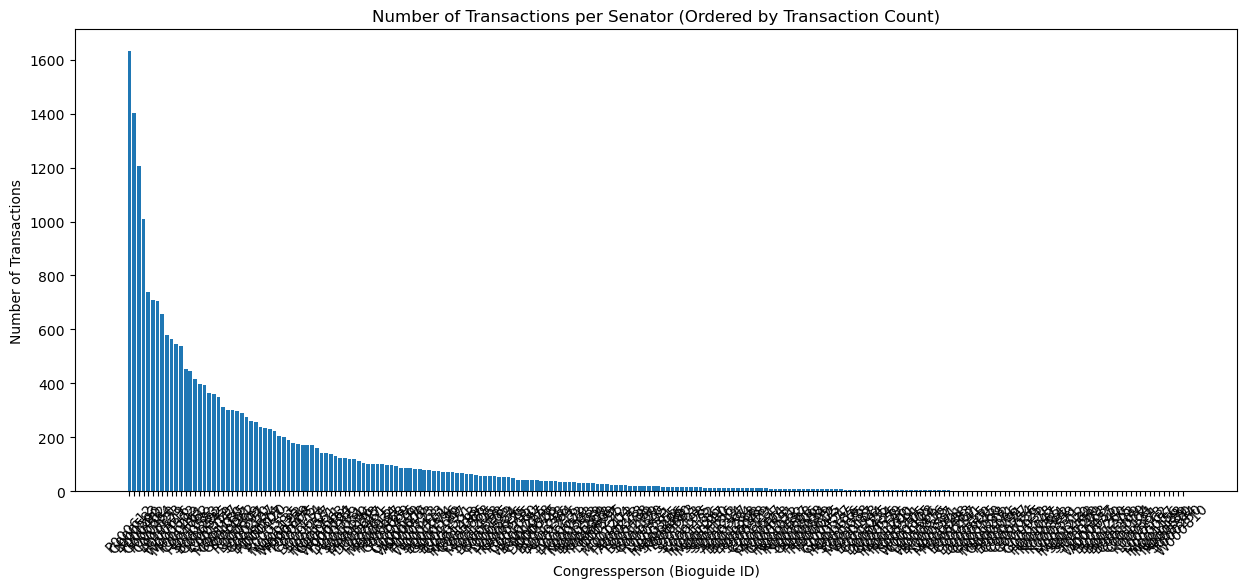

226
[1630, 1403, 1206, 1010, 739, 710, 707, 659, 580, 563, 546, 540, 452, 445, 417, 398, 395, 365, 361, 350, 314, 302, 300, 298, 289, 275, 261, 259, 238, 234, 233, 225, 205, 203, 190, 181, 175, 173, 173, 171, 161, 143, 141, 140, 133, 123, 123, 122, 121, 111, 107, 103, 102, 101, 100, 97, 97, 93, 88, 86, 86, 82, 82, 81, 79, 76, 76, 73, 73, 72, 69, 68, 65, 64, 60, 59, 58, 57, 56, 55, 54, 52, 50, 44, 43, 43, 42, 42, 40, 39, 38, 37, 35, 35, 35, 35, 33, 31, 31, 30, 29, 28, 26, 25, 25, 24, 23, 22, 22, 21, 21, 19, 19, 19, 18, 18, 18, 17, 16, 15, 15, 15, 15, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
transaction_count = defaultdict(int)

for _, row in transc_data.iterrows():
    bioguide_id = row[0]
    transaction_count[bioguide_id] += 1

sorted_transactions = sorted(transaction_count.items(), key=lambda x: x[1], reverse=True)
bioguide_ids = [item[0] for item in sorted_transactions]
transaction_counts = [item[1] for item in sorted_transactions]

plt.figure(figsize=(15, 6))
plt.bar(bioguide_ids, transaction_counts)
plt.xlabel('Congressperson (Bioguide ID)')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Senator (Ordered by Transaction Count)')
plt.xticks(rotation=45)
plt.show()
print(len(bioguide_ids))
print(transaction_counts)

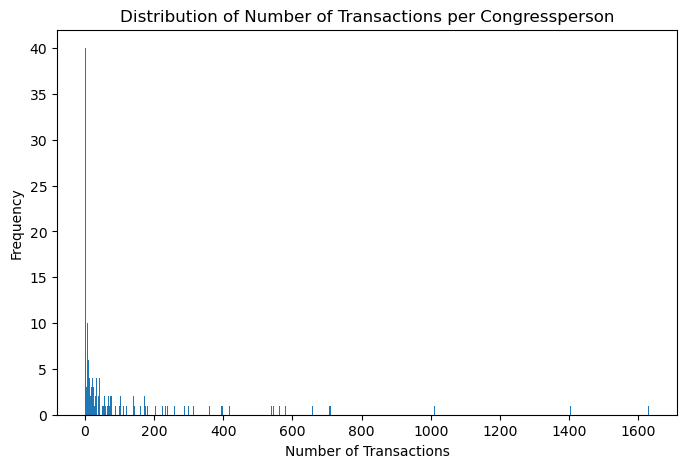

In [8]:
import matplotlib.pyplot as plt

transaction_count = defaultdict(int)
for _, row in transc_data.iterrows():
    bioguide_id = row[0]
    transaction_count[bioguide_id] += 1

transaction_counts = list(transaction_count.values())

plt.figure(figsize=(8, 5))
plt.hist(transaction_counts, bins=1000)
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Transactions per Congressperson')
plt.show()

2022-08-26
117th
2021-02-08
117th
2020-12-16
116th
2021-03-18
117th
2021-06-18
117th
2021-06-07
117th
2021-06-24
117th
2021-10-29
117th
2021-03-18
117th
2021-08-05
117th
2021-08-14
117th
2021-08-18
117th
2020-12-03
116th
2021-09-17
117th
2021-03-18
117th
2021-09-21
117th
2021-06-18
117th
2021-08-06
117th
2021-11-26
117th
2020-12-07
116th
2020-12-02
116th
2021-06-17
117th
2021-03-02
117th
2021-04-14
117th
2021-01-19
117th
2021-02-19
117th
2021-01-19
117th
2021-08-28
117th
2021-05-06
117th
2021-06-21
117th
2021-10-04
117th
2021-02-26
117th
2021-06-24
117th
2021-05-06
117th
2021-09-17
117th
2020-12-15
116th
2021-02-04
117th
2021-03-11
117th
2021-03-18
117th
2021-05-17
117th
2021-10-29
117th
2021-01-11
117th
2021-05-13
117th
2020-12-03
116th
2021-03-18
117th
2020-12-23
116th
2021-06-18
117th
2021-04-29
117th
2021-05-06
117th
2021-06-08
117th
2021-06-17
117th
2021-07-21
117th
2021-01-11
117th
2021-01-15
117th
2021-01-15
117th
2021-07-21
117th
2021-09-20
117th
2021-10-29
117th
2021-10-04
117

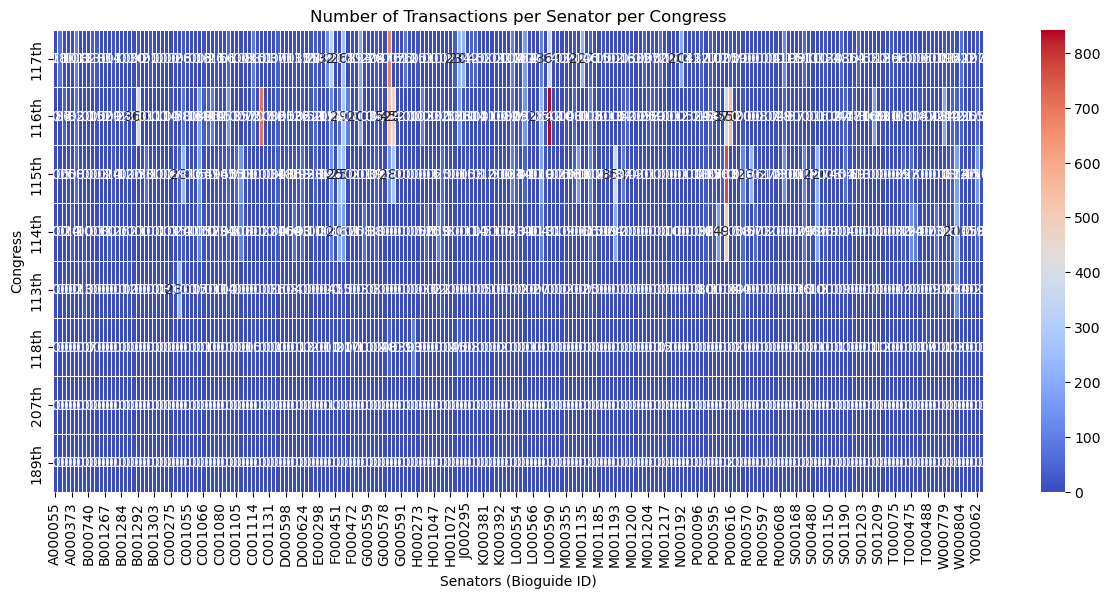

In [10]:
transaction_count = defaultdict(lambda: defaultdict(int))
from tqdm import tqdm
for _, row in tqdm(transc_data.iterrows()):
    bioguide_id = row[0]
    # print(bioguide_id)
    name = row[1]
    # print(full_name)
    trans_date = row[3]
    congress = get_congress_number(str(trans_date))
    print(str(trans_date))
    print(congress)
    transaction_count[bioguide_id][congress] += 1
    transaction_df = pd.DataFrame(transaction_count).fillna(0)

plt.figure(figsize=(15, 6))
sns.heatmap(transaction_df, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.0f')
plt.xlabel('Senators (Bioguide ID)')
plt.ylabel('Congress')
plt.title('Number of Transactions per Senator per Congress')
plt.show()
# print(transaction_count.keys())

In [11]:
transaction_df = transaction_df.drop(['207th', '189th'], axis=0)
transaction_df

,A000055,A000076,A000364,A000367,A000373,B000574,B000575,B000589,B000740,B001248,...,W000779,W000797,W000800,W000802,W000804,W000805,W000810,W000816,Y000062,Y000063
117th,1.0,78.0,1.0,0.0,0.0,108.0,1.0,0.0,1.0,33.0,...,19.0,11.0,15.0,4.0,72.0,1.0,0.0,0.0,27.0,0.0
116th,0.0,8.0,37.0,6.0,0.0,83.0,2.0,0.0,0.0,0.0,...,184.0,1.0,42.0,42.0,42.0,3.0,1.0,0.0,55.0,0.0
115th,0.0,0.0,0.0,5.0,0.0,68.0,0.0,0.0,0.0,0.0,...,0.0,13.0,31.0,174.0,13.0,2.0,0.0,0.0,157.0,10.0
114th,0.0,0.0,0.0,1.0,24.0,0.0,0.0,10.0,0.0,0.0,...,0.0,16.0,0.0,209.0,11.0,0.0,0.0,5.0,59.0,8.0
113th,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,0.0,0.0,...,0.0,2.0,0.0,134.0,0.0,0.0,0.0,0.0,2.0,0.0
118th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [12]:
cgp_congress_pairs = []

# Iterate through the rows of transaction_df
for idx, row in transaction_df.iterrows():
    congress_num = int(idx[:-2])  # Extract the congress number as an integer
    # Iterate through the columns (bioguide_id) of the row
    for bioguide_id, value in row.iteritems():
        # Check if the value is greater than or equal to 5
        if value >= 5 and congress_num >= 115:
            cgp_congress_pairs.append((bioguide_id, congress_num))

print(cgp_congress_pairs)
print(len(cgp_congress_pairs))

[('A000076', 117), ('B000574', 117), ('B001248', 117), ('B001255', 117), ('B001274', 117), ('B001292', 117), ('B001299', 117), ('C001047', 117), ('C001055', 117), ('C001066', 117), ('C001068', 117), ('C001078', 117), ('C001101', 117), ('C001114', 117), ('C001120', 117), ('D000399', 117), ('D000617', 117), ('D000624', 117), ('D000628', 117), ('E000296', 117), ('E000298', 117), ('F000187', 117), ('F000450', 117), ('F000462', 117), ('F000472', 117), ('G000545', 117), ('G000563', 117), ('G000583', 117), ('G000588', 117), ('G000591', 117), ('G000596', 117), ('G000597', 117), ('H000273', 117), ('H001079', 117), ('H001082', 117), ('J000020', 117), ('J000305', 117), ('K000375', 117), ('L000397', 117), ('L000559', 117), ('L000579', 117), ('L000590', 117), ('M000934', 117), ('M001135', 117), ('M001180', 117), ('M001186', 117), ('M001199', 117), ('M001200', 117), ('M001203', 117), ('M001205', 117), ('M001213', 117), ('N000192', 117), ('P000048', 117), ('P000197', 117), ('P000593', 117), ('P000595

In [13]:
transc_data

naics_distribution = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

transc_data.head(10)

for _, row in transc_data.iterrows():
    bioguide_id = row[0]
    trans_date = row[3]
    naics = row[4]
    congress = get_congress_number(str(trans_date))
    for elem in naics:
        if elem != '':
            naics_distribution[bioguide_id][int(congress[:-2])][elem[:2]] += 1

naics_distribution

defaultdict(<function __main__.<lambda>()>,
            {'A000055': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {117: defaultdict(int, {'33': 2})}),
             'A000076': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {117: defaultdict(int,
                                      {'52': 16,
                                       '44': 5,
                                       '45': 11,
                                       '33': 19,
                                       '51': 12,
                                       '48': 3,
                                       '35': 3,
                                       '32': 11,
                                       '21': 7,
                                       '54': 9,
                                       '42': 1,
                                       '56': 5,
                                       '22': 6,
                                       '31': 

  0%|          | 0/226 [00:00<?, ?it/s]

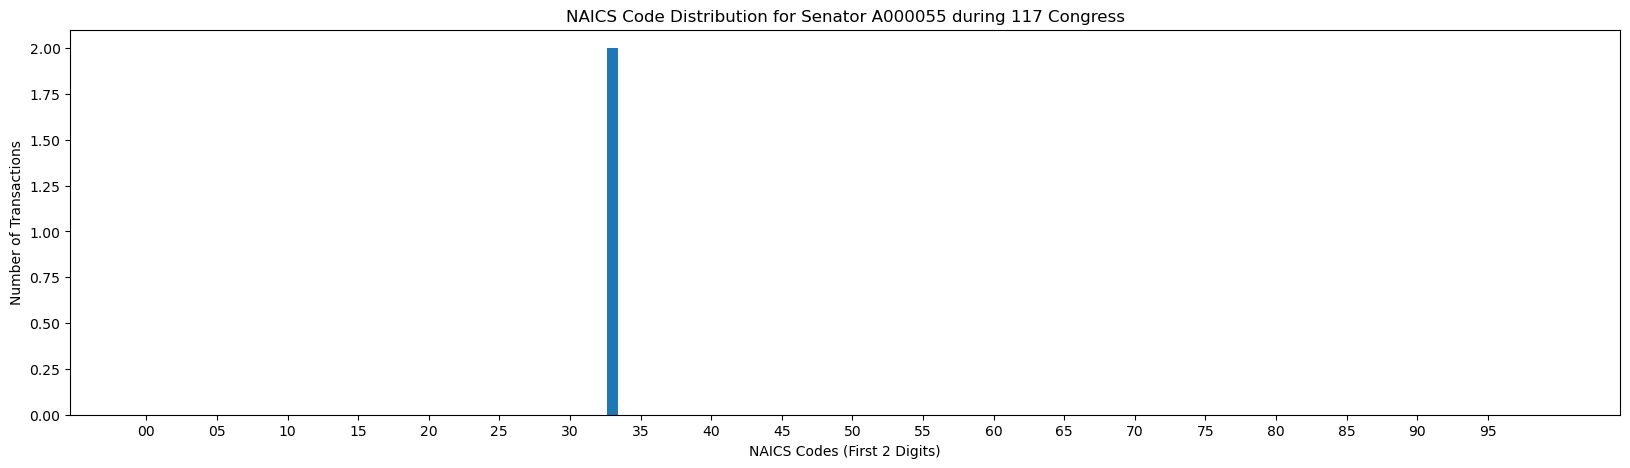

  0%|          | 0/226 [00:00<?, ?it/s]


In [14]:
def plot_naics_distribution(bioguide_id, congress, naics_count):
    full_naics_count = {str(i).zfill(2): 0 for i in range(100)}
    full_naics_count.update(naics_count)

    naics_codes = sorted(full_naics_count.keys())
    counts = [full_naics_count[naics] for naics in naics_codes]

    plt.figure(figsize=(20, 5))
    plt.bar(naics_codes, counts)
    plt.xticks(range(0, 100, 5))
    plt.xlabel('NAICS Codes (First 2 Digits)')
    plt.ylabel('Number of Transactions')
    plt.title(f'NAICS Code Distribution for Senator {bioguide_id} during {congress} Congress')
    plt.show()

for bioguide_id, congress_transactions in tqdm(naics_distribution.items()):
    for congress, naics_count in congress_transactions.items():
        plot_naics_distribution(bioguide_id, congress, naics_count)
    break

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


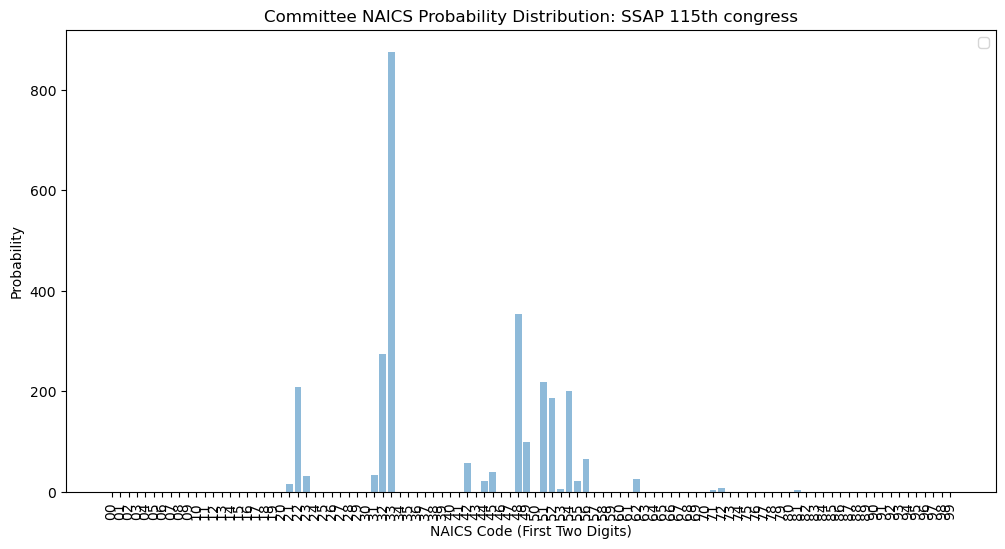

In [22]:
# Assuming the SQL query output is stored in a DataFrame named 'committee_df'

def get_probability_distribution(naics_count):
    total_transactions = sum(naics_count.values())
    return {naics: count / total_transactions for naics, count in naics_count.items()}

def plot_committee_naics_probability_distribution(committee_naics_prob_dist, selected_congress_num, selected_committee_thomas_id):
    x_labels = [str(i).zfill(2) for i in range(100)]
    y_values = [committee_naics_prob_dist.get(label, 0) for label in x_labels]
    
    x = np.arange(len(x_labels))
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, y_values, align='center', alpha=0.5)
    plt.xticks(x, x_labels, rotation='vertical')
    plt.xlabel('NAICS Code (First Two Digits)')
    plt.ylabel('Probability')
    plt.title(f'Committee NAICS Probability Distribution: {selected_committee_thomas_id} {selected_congress_num}th congress')


import pandas as pd
from collections import defaultdict

committee_naics_dist = defaultdict(int)

selected_congress_num = 115 
selected_committee_thomas_id = "SSAP"

filtered_committee_rows = committee_rows[
    (committee_rows['congress_num'] == selected_congress_num) &
    (committee_rows['committee_thomas_id'] == selected_committee_thomas_id)
]

# Iterate through the rows of the fetched committee_rows
for _, row in filtered_committee_rows.iterrows():
    # print(row)
    naics_array = row[3]
    for naics in naics_array:
        if naics != '':
            committee_naics_dist[naics[:2]] += 1        
# Normalize the counts to create a probability distribution
committee_prob_dist = get_probability_distribution(committee_naics_dist)

# Call the previously defined function to plot the probability distribution
plot_committee_naics_probability_distribution(committee_naics_dist, selected_congress_num, selected_committee_thomas_id)
plt.legend()
plt.show()

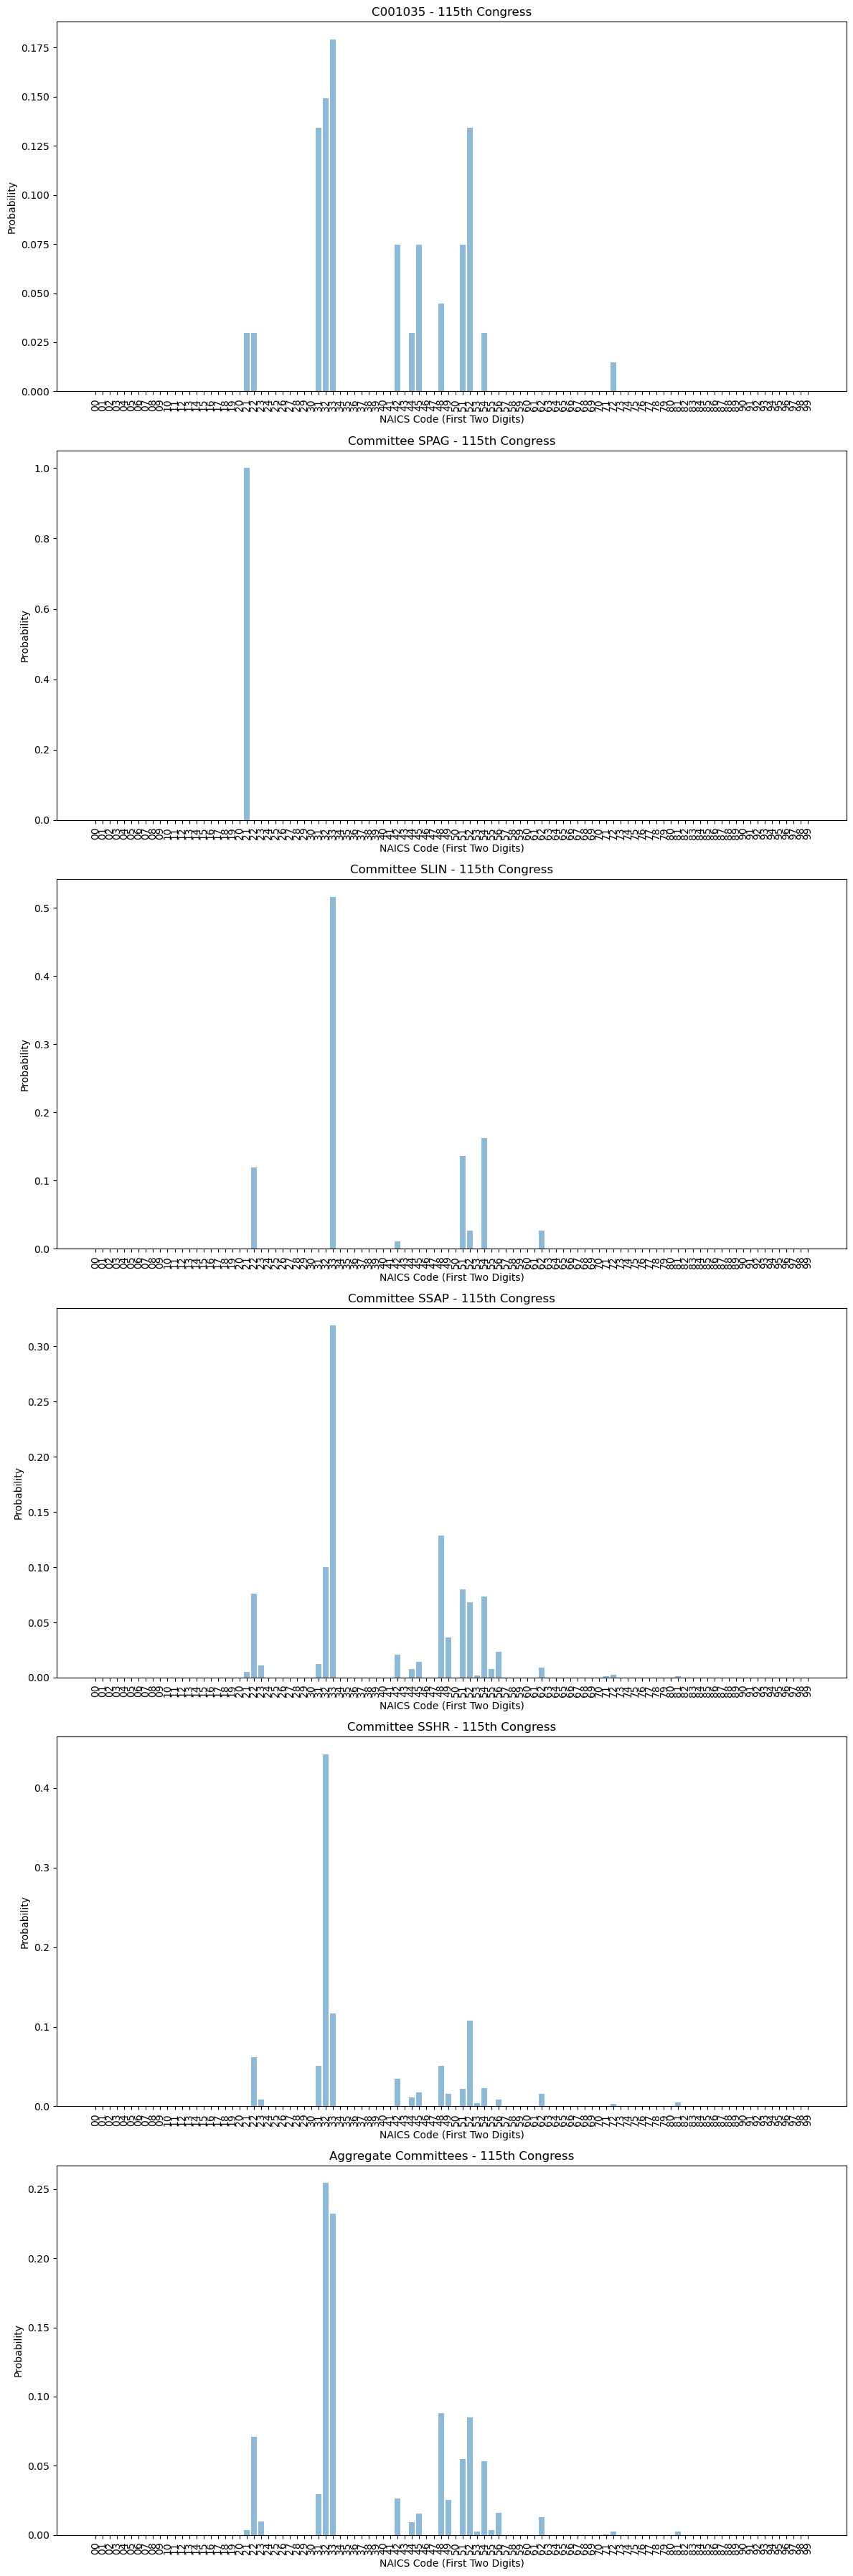

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def get_committee_naics_dist(committee_id, congress_num):
    committee_naics_dist = defaultdict(int)

    filtered_committee_rows = committee_rows[
    (committee_rows['congress_num'] == congress_num) &
    (committee_rows['committee_thomas_id'] == committee_id)
    ]

    # Iterate through the rows of the fetched committee_rows
    for _, row in filtered_committee_rows.iterrows():
        # print(row)
        naics_array = row[3]
        for naics in naics_array:
            if naics != '':
                committee_naics_dist[naics[:2]] += 1        
            
    return committee_naics_dist

def get_cgp_naics_dist(bioguide_id, congress_num):
    naics_distribution = defaultdict(int)
    filtered_cgp_data = transc_data[transc_data['bioguide_id'] == bioguide_id]

    for _, row in filtered_cgp_data.iterrows():
        bioguide_id = row[0]
        trans_date = row[3]
        naics = row[4]
        congress = get_congress_number(str(trans_date))
        congress = int(congress[:-2])

        # print(congress, congress_num)
        if congress == congress_num:
            for elem in naics:
                # print(elem)
                # print(type(elem))
                # print(congress)
                if elem != '':
                    naics_distribution[elem[:2]] += 1
    # print(naics_distribution)
    return naics_distribution

def get_committees_for_senator_and_congress(bioguide_id, congress_num):

    filtered_committee_assignments = committee_assignments[
    (committee_assignments['congress_num'] == congress_num) &
    (committee_assignments['legislator_bioguide_id'] == bioguide_id)
    ]
    return [row[0] for _, row in filtered_committee_assignments.iterrows()]

def plot_naics_probability_distribution(ax, naics_prob_dist, title):
    x_labels = [str(i).zfill(2) for i in range(100)]
    y_values = [naics_prob_dist.get(label, 0) for label in x_labels]
    
    x = np.arange(len(x_labels))
    
    ax.bar(x, y_values, align='center', alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation='vertical')
    ax.set_xlabel('NAICS Code (First Two Digits)')
    ax.set_ylabel('Probability')
    ax.set_title(title)

def compare_senator_and_committees_naics(bioguide_id, congress_num):
    committees = get_committees_for_senator_and_congress(bioguide_id, congress_num)

    # Get senator's NAICS probability distribution
    cgp_naics_dist = get_cgp_naics_dist(bioguide_id, congress_num)
    cgp_prob_dist = get_probability_distribution(cgp_naics_dist)

    # Create a subplot for each committee, one for the senator, and one for the aggregate committee
    n_plots = len(committees) + 2
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

    # Plot senator's NAICS probability distribution
    plot_naics_probability_distribution(axes[0], cgp_prob_dist, f"{bioguide_id} - {congress_num}th Congress")

    # Initialize aggregate committee NAICS distribution
    aggregate_committee_naics_dist = defaultdict(int)

    # Iterate through committees and plot their NAICS probability distribution
    for i, committee_id in enumerate(committees):
        committee_naics_dist = get_committee_naics_dist(committee_id, congress_num)
        committee_prob_dist = get_probability_distribution(committee_naics_dist)

        plot_naics_probability_distribution(axes[i + 1], committee_prob_dist, f"Committee {committee_id} - {congress_num}th Congress")

        # Update aggregate committee NAICS distribution
        for naics, count in committee_naics_dist.items():
            aggregate_committee_naics_dist[naics] += count

    # Plot aggregate committee NAICS probability distribution
    aggregate_committee_prob_dist = get_probability_distribution(aggregate_committee_naics_dist)
    plot_naics_probability_distribution(axes[-1], aggregate_committee_prob_dist, f"Aggregate Committees - {congress_num}th Congress")

    plt.tight_layout()
    plt.show()

# Replace 'senator_bioguide_id' and 'senator_congress_num' with actual values
senator_bioguide_id = "C001035"
senator_congress_num = 115

compare_senator_and_committees_naics(senator_bioguide_id, senator_congress_num)

In [52]:
cgp_congress_pairs = []

# Iterate through the rows of transaction_df
for idx, row in transaction_df.iterrows():
    congress_num = int(idx[:-2])  # Extract the congress number as an integer
    # Iterate through the columns (senator_id) of the row
    for bio_id, value in row.iteritems():
        # Check if the value is greater than or equal to 5
        if value >= 5:
            cgp_congress_pairs.append((bio_id, congress_num))

print(cgp_congress_pairs)
print(len(cgp_congress_pairs))

[('A000076', 117), ('B000574', 117), ('B001248', 117), ('B001255', 117), ('B001274', 117), ('B001292', 117), ('B001299', 117), ('C001047', 117), ('C001055', 117), ('C001066', 117), ('C001068', 117), ('C001078', 117), ('C001101', 117), ('C001114', 117), ('C001120', 117), ('D000399', 117), ('D000617', 117), ('D000624', 117), ('D000628', 117), ('E000296', 117), ('E000298', 117), ('F000187', 117), ('F000450', 117), ('F000462', 117), ('F000472', 117), ('G000545', 117), ('G000563', 117), ('G000583', 117), ('G000588', 117), ('G000591', 117), ('G000596', 117), ('G000597', 117), ('H000273', 117), ('H001079', 117), ('H001082', 117), ('J000020', 117), ('J000305', 117), ('K000375', 117), ('L000397', 117), ('L000559', 117), ('L000579', 117), ('L000590', 117), ('M000934', 117), ('M001135', 117), ('M001180', 117), ('M001186', 117), ('M001199', 117), ('M001200', 117), ('M001203', 117), ('M001205', 117), ('M001213', 117), ('N000192', 117), ('P000048', 117), ('P000197', 117), ('P000593', 117), ('P000595

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Calculate cross-entropy between two probability distributions
def cross_entropy(p, q):
    ce = 0
    for key in p:
        if key in q and q[key] > 0:
            ce += p[key] * np.log(q[key])
    return -ce

# Initialize an empty DataFrame to store the cross-entropy values
columns = ["senator", "congress", "committee", "cross_entropy"]
cross_entropy_df = pd.DataFrame(columns=columns)

# Iterate through the senator, congress pairs
for senator, congress in tqdm(cgp_congress_pairs):
    senator_naics_dist = get_cgp_naics_dist(senator, congress)
    senator_prob_dist = get_probability_distribution(senator_naics_dist)

    committees = get_committees_for_senator_and_congress(senator, congress)
    for committee in committees:
        committee_naics_dist = get_committee_naics_dist(committee, congress)
        committee_prob_dist = get_probability_distribution(committee_naics_dist)

        ce = cross_entropy(senator_prob_dist, committee_prob_dist)
        cross_entropy_df = cross_entropy_df.append({"senator": senator,
                                                    "congress": congress,
                                                    "committee": committee,
                                                    "cross_entropy": ce},
                                                   ignore_index=True)

    # Calculate cross-entropy with aggregate committee
    aggregate_committee_naics_dist = defaultdict(int)
    for committee in committees:
        committee_naics_dist = get_committee_naics_dist(committee, congress)
        for naics, count in committee_naics_dist.items():
            aggregate_committee_naics_dist[naics] += count
    aggregate_committee_prob_dist = get_probability_distribution(aggregate_committee_naics_dist)

    ce = cross_entropy(senator_prob_dist, aggregate_committee_prob_dist)
    cross_entropy_df = cross_entropy_df.append({"senator": senator,
                                                "congress": congress,
                                                "committee": "Aggregate",
                                                "cross_entropy": ce},
                                               ignore_index=True)

# Visualize cross-entropy values in a plot
plt.figure(figsize=(12, 6))
for committee in cross_entropy_df["committee"].unique():
    committee_df = cross_entropy_df[cross_entropy_df["committee"] == committee]
    plt.plot(committee_df["senator"] + " - " + committee_df["congress"].astype(str),
             committee_df["cross_entropy"], label=committee, marker="o")

plt.xlabel("Senator - Congress")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy Between Senator and Committee NAICS Distributions")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [55]:
cgp_congress_pairs[23]

('F000462', 117)

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.text import Text
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to get the list of committee codes
def get_committee_codes():
    # Replace this list with the actual committee codes
    return ['HSCN', 'SSBU', 'HSGO', 'SSEG', 'HSBU', 'HSEF', 'HSIJ', 'SLIA', 'HLET', 'HSSM', 'HSIF', 'HSMM', 'HSAG', 'HHAH', 'SSAP', 'SSAS', 'HSFA', 'SPOC', 'HSPO', 'HSAP', 'SCNC', 'SPWW', 'SSAE', 'HSVR', 'HSHM', 'HSUA', 'SPIM', 'SSAF', 'HSWM', 'HLCQ', 'HSRU', 'SSVA', 'SSCM', 'SSSB', 'HSAS', 'SSDT', 'HLIG', 'HSSO', 'HSMH', 'HSBA', 'SPAG', 'SSRA', 'SLIN', 'HSGW', 'HSVC', 'HSSY', 'SLET', 'SSFR', 'HSED', 'SSPO', 'SSHR', 'HLOC', 'SSJU', 'HSHA', 'HSAT', 'HSII', 'HSPW', 'SSBK', 'SSGA', 'HSDT', 'SLPO', 'HSJU', 'SSFI', 'SSEV', 'HTDE']


from scipy.stats import entropy

def update_dict(dct):
    for i in range(10, 100):
        key = str(i)
        if key not in dct:
            dct[key] = 1e-10
    return dct

def compute_cross_entropy(p, q):
    p = update_dict(p)
    q = update_dict(q)

    return entropy(list(p.values()), list(q.values()))

committees = get_committee_codes() + ["Aggregate"]

# Initialize an empty DataFrame to store the cross-entropy values
columns = ["senator", "congress", "committee", "cross_entropy"]
cross_entropy_df = pd.DataFrame(columns=columns)

# Iterate through the senator, congress pairs
for senator, congress in tqdm(cgp_congress_pairs):    
    senator_naics_dist = get_cgp_naics_dist(senator, congress)
    senator_prob_dist = get_probability_distribution(senator_naics_dist)

    assigned_committees = get_committees_for_senator_and_congress(senator, congress)

    aggregate_committee_naics_dist = defaultdict(int)
    for committee in committees:
        if committee != "Aggregate":
            committee_naics_dist = get_committee_naics_dist(committee, congress)
            committee_naics_prob_dist = get_probability_distribution(committee_naics_dist)

            for naics, count in committee_naics_dist.items():
                aggregate_committee_naics_dist[naics] += count


        cross_entropy = compute_cross_entropy(senator_prob_dist, committee_naics_prob_dist)
        cross_entropy_df = cross_entropy_df.append({"senator": senator,
                                                    "congress": congress,
                                                    "committee": committee,
                                                    "cross_entropy": cross_entropy},
                                                   ignore_index=True)
    
    aggregate_committee_prob_dist = get_probability_distribution(aggregate_committee_naics_dist)
    cross_entropy = compute_cross_entropy(senator_prob_dist, aggregate_committee_prob_dist)

    if len(assigned_committees) == 0:
        cross_entropy= np.inf

    cross_entropy_df = cross_entropy_df.append({"senator": senator,
                                                    "congress": congress,
                                                    "committee": "Aggregate",
                                                    "cross_entropy": cross_entropy},
                                                   ignore_index=True)
    # break

# Pivot the DataFrame to create a matrix with senators, congress numbers, and committees
pivot_df = cross_entropy_df.pivot_table(values="cross_entropy",
                                        index=["senator", "congress"],
                                        columns="committee",
                                        fill_value=0)



100%|██████████| 339/339 [15:34<00:00,  2.76s/it]


In [57]:
pivot_df
pivot_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pivot_df
# pivot_df.mean()

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
A000076 116             NaN  2.838487  2.838487  2.838487  0.761769  2.838487   
        117             NaN  1.994510  1.994510  1.994510  0.521573  1.994510   
A000364 116             NaN  2.080461  2.080461  2.080461  0.945896  2.080461   
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
...                     ...       ...       ...       ...       ...       ...   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 114             NaN  3.268878  3.268878  3.268878  1.074649  3.268878   
        115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSEV  \
senator congress                                          ...             
A000076 116       1.124205  0.843289  2.437729  2.838487  ...  0.700261   
        117       1.040841  0.628032  0.404431  1.994510  ...  0.908134   
A000364 116       0.574210  0.743707  1.839397  2.080461  ...  0.655662   
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.826874   
        116       1.049994  1.174849  1.539766  2.492253  ...  0.449228   
...                    ...       ...       ...       ...  ...       ...   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.800988   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.524634   
        117       1.443406  0.917788  0.708776  2.189661  ...  1.017068   
Y000063 114       0.709191  1.115307  3.373584  3.268878  ...  1.434535   
        115       1.325228  0.965332  0.983607  3.016054  ...  1.925699   

committee             SSFI      SSFR      SSGA      SSHR      SSJU      SSPO  \
senator congress                                                               
A000076 116       0.747220  1.010105  0.925417  0.464875  0.679325  2.838487   
        117       0.932682  4.017124  0.546993  0.573883  0.662098  1.994510   
A000364 116       0.175522  1.021154  0.591030  0.530559  0.666639  2.080461   
A000367 115       0.901126  0.785693  0.825169  1.040361  1.000287  2.526808   
        116       0.865982  1.315268  0.817794  0.740687  0.897260  2.492253   
...                    ...       ...       ...       ...       ...       ...   
Y000062 115       0.887576  1.149926  1.091550  0.980916  1.091251  1.911668   
        116       0.511955  0.743672  0.495603  0.515490  0.819876  2.034654   
        117       1.201255  3.937793  0.431914  1.087356  0.959601  2.189661   
Y000063 114       1.133967  0.576989  1.290782  1.280473  0.882297  3.268878   
        115       1.236722  0.956680  1.074659  0.813844  2.818082  3.016054   

committee              SSRA      SSSB      SSVA  
senator congress                                 
A000076 116        6.641782  0.735877  1.161677  
        117        9.210612  6.179240  8.430289  
A000364 116       10.927072  0.299179  3.226855  
A000367 115        0.291676  0.664019  1.056676  
        116       13.373932  0.652843  0.785270  
...                     ...       ...       ...  
Y000062 115        5.757342  3.014428  4.008703  
        116       10.448575  0.210645  4.889986  
        117        7.718390  4.867120  5.925283  
Y000063 114        9.668030  1.357093  0.940208  
        115        1.285354  1.599377  0.838250  

[339 rows x 66 columns]

In [58]:
# pickle pivot_df
import pickle
with open('pivot_df.pickle', 'wb') as handle:
    pickle.dump(pivot_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from matplotlib.colors import Normalize

# Find the min and max values for normalization
vmin = pivot_df.min().min()
vmax = pivot_df.max().max()
norm = Normalize(vmin=vmin, vmax=vmax)

for i, (index, row) in enumerate(pivot_df.iterrows()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 4]})
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
    
    senator, congress = index[0], index[1]
    assigned_committees = get_committees_for_senator_and_congress(senator, congress)
    assigned_committees = [committee for committee in assigned_committees if committee.startswith("S")]
    print(senator, congress, assigned_committees)



    assigned_committees.append("Aggregate")

    sns.heatmap(row[assigned_committees].to_frame().T,
                cmap="YlGnBu", linewidths=0.5, linecolor="black", annot=True, fmt=".2f", ax=ax1, cbar=False, norm=norm)

    sns.heatmap(row[[committee for committee in committees if committee not in assigned_committees]].to_frame().T,
                cmap="YlGnBu", linewidths=0.5, linecolor="black", annot=True, fmt=".2f", ax=ax2, cbar_ax=cbar_ax, norm=norm)

    ax1.set_ylabel(f"{senator} - {congress}")

    for label in ax1.get_xticklabels():
        label.set_text(f"{label.get_text()}")

    fig.text(0.5, 0.08, "Committee", ha='center', va='center')
    fig.suptitle("Cross-Entropy of Senator and Committee NAICS Probability Distributions")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
    plt.close(fig)

In [92]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

assigned_ce = []
unassigned_ce = []

for _, (index, row) in enumerate(pivot_df.iterrows()):
    senator, congress = index[0], index[1]
    assigned_committees = get_committees_for_senator_and_congress(senator, congress)
    if len(assigned_committees) == 0:
        continue

    for committee in row.index:
        if committee == "Aggregate":
            continue

        ce_value = row[committee]
        if np.isnan(ce_value):
            continue

        if committee in assigned_committees:
            assigned_ce.append(ce_value)
        else:
            unassigned_ce.append(ce_value)



t_stat, p_value = ttest_ind(assigned_ce, unassigned_ce, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.9f}")

alpha = 0.05
if p_value < alpha:
    print("The means of cross-entropy values for assigned and unassigned committees are significantly different.")
else:
    print("There is no significant difference between the means of cross-entropy values for assigned and unassigned committees.")

T-statistic: -6.2662
P-value: 0.000000001
The means of cross-entropy values for assigned and unassigned committees are significantly different.


In [101]:
import numpy as np

mean1 = np.mean(assigned_ce)
mean2 = np.mean(unassigned_ce)
sd1 = np.std(assigned_ce, ddof=1)  # ddof=1 for sample standard deviation
sd2 = np.std(unassigned_ce, ddof=1)
n1 = len(assigned_ce)
n2 = len(unassigned_ce)

pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
cohens_d = (mean1 - mean2) / pooled_sd

print(f"Cohen's d: {cohens_d:.4f}")

Cohen's d: -0.2757


In [102]:
import numpy as np

mean1 = np.mean(assigned_ce)
mean2 = np.mean(unassigned_ce)
sd1 = np.std(assigned_ce, ddof=1)  # ddof=1 for sample standard deviation
sd2 = np.std(unassigned_ce, ddof=1)
n1 = len(assigned_ce)
n2 = len(unassigned_ce)

pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
correction_factor = 1 - 3 / (4 * (n1 + n2) - 9)
hedges_g = (mean1 - mean2) / pooled_sd * correction_factor

print(f"Hedges' g: {hedges_g:.4f}")

Hedges' g: -0.2757


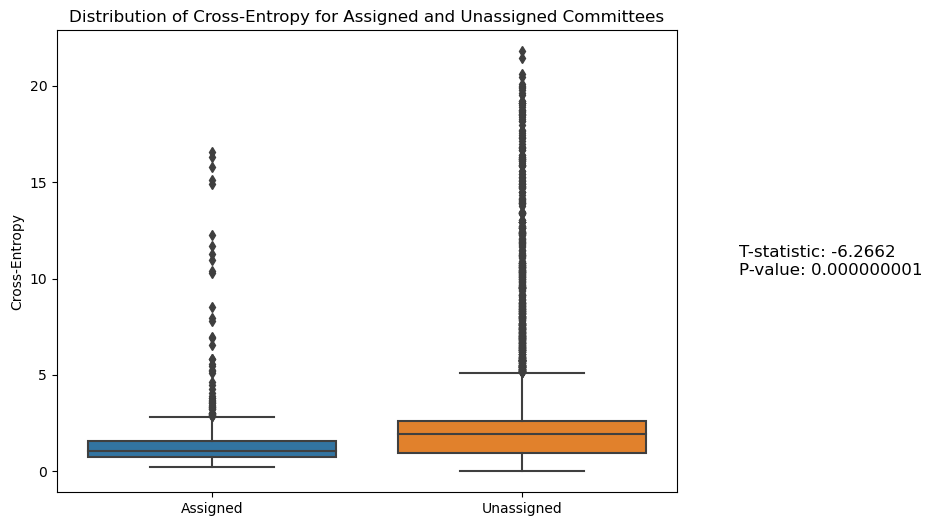

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[assigned_ce, unassigned_ce], notch=False)
plt.xticks([0, 1], ['Assigned', 'Unassigned'])
plt.ylabel('Cross-Entropy')
plt.title('Distribution of Cross-Entropy for Assigned and Unassigned Committees')

# Display the t-test result on the plot
result_text = f"T-statistic: {t_stat:.4f}\nP-value: {p_value:.9f}"
plt.text(
    1.1,
    0.5,
    result_text,
    fontsize=12,
    verticalalignment='center',
    transform=plt.gca().transAxes,
)

# Show the plot
plt.show()
print(len(assigned_ce), len(unassigned_ce))

In [62]:
print(len(assigned_ce))

572


In [63]:
print(len(unassigned_ce))

14703


In [66]:
pivot_df.index
pivot_df['SSFI']

senator  congress
A000076  116         0.747220
         117         0.932682
A000364  116         0.175522
A000367  115         0.901126
         116         0.865982
                       ...   
Y000062  115         0.887576
         116         0.511955
         117         1.201255
Y000063  114         1.133967
         115         1.236722
Name: SSFI, Length: 339, dtype: float64

In [67]:
df = pivot_df.copy()
cmm = 'SSFI'

for bio, cgn in pivot_df.index:
    cmms = get_committees_for_senator_and_congress(bio, cgn)
    if cmm in cmms:
        df.loc[(bio, cgn), 'AssignedToCommittee'] = 1
    else:
        df.loc[(bio, cgn), 'AssignedToCommittee'] = 0

for bio, cgn in pivot_df.index:
    lagged_cgn = cgn - 1
    cmms = get_committees_for_senator_and_congress(bio, lagged_cgn)
    if cmm in cmms:
        df.loc[(bio, cgn), 'LaggedCommitteeAssignments'] = 1
    else:
        df.loc[(bio, cgn), 'LaggedCommitteeAssignments'] = 0



In [68]:
import pandas as pd
from linearmodels import PanelOLS
from linearmodels.panel import PooledOLS
from linearmodels.panel.data import PanelData

# Define the dependent variable (y) and the independent variables (X)
y = cmm  # Replace this with the actual column name for the dependent variable
X = ['AssignedToCommittee', 'LaggedCommitteeAssignments']

# Fit the fixed effects model
model = PanelOLS(df[cmm], df[X], entity_effects=True, time_effects=True)
results = model.fit()

# Print the summary of the regression model
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   SSFI   R-squared:                        0.0109
Estimator:                   PanelOLS   R-squared (Between):             -0.0068
No. Observations:                 339   R-squared (Within):               0.0061
Date:                Wed, Mar 29 2023   R-squared (Overall):             -0.0117
Time:                        18:46:04   Log-likelihood                    26.416
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.9216
Entities:                         164   P-value                           0.3999
Avg Obs:                       2.0671   Distribution:                   F(2,168)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             0.9216
                            

In [73]:
import pandas as pd
from linearmodels import PanelOLS
from linearmodels.panel.data import PanelData

def fit_panel_ols_for_committee(df, committee_code):
    # Preprocess the DataFrame for the given committee code
    try:
        df = df.copy()
        
        for bio, cgn in df.index:
            cmms = get_committees_for_senator_and_congress(bio, cgn)
            if committee_code in cmms:
                df.loc[(bio, cgn), f'AssignedTo{committee_code}'] = 1
            else:
                df.loc[(bio, cgn), f'AssignedTo{committee_code}'] = 0

            lagged_cgn = cgn - 1
            cmms = get_committees_for_senator_and_congress(bio, lagged_cgn)
            if committee_code in cmms:
                df.loc[(bio, cgn), f'Lagged{committee_code}Assignments'] = 1
            else:
                df.loc[(bio, cgn), f'Lagged{committee_code}Assignments'] = 0

        # Define the dependent variable (y) and the independent variables (X)
        y = committee_code
        X = [f'AssignedTo{committee_code}', f'Lagged{committee_code}Assignments']

        # Fit the fixed effects model
        model = PanelOLS(df[y], df[X], entity_effects=True, time_effects=True)
        results = model.fit()
    
        return results
    except Exception as e:
        print(f"Error for committee {committee_code}: {e}")
        return None

# Get the list of committee codes
committee_codes = get_committee_codes()

# Fit the PanelOLS model for all committees
results = {committee_code: fit_panel_ols_for_committee(pivot_df, committee_code) for committee_code in committee_codes}


Error for committee HSEF: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.
Error for committee HSIJ: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.
Error for committee SLIA: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          AssignedToSLIA

Set drop_absorbed=True to automatically drop absorbed variables.

Error for committee HLET: exog does not have full column rank. If you wish to proceed with model estimation irrespec

In [74]:
results

{'HSCN':                           PanelOLS Estimation Summary                           
 Dep. Variable:                   HSCN   R-squared:                        0.0504
 Estimator:                   PanelOLS   R-squared (Between):              0.0102
 No. Observations:                 339   R-squared (Within):               0.0502
 Date:                Wed, Mar 29 2023   R-squared (Overall):              0.0099
 Time:                        18:59:04   Log-likelihood                   -37.712
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      4.4615
 Entities:                         164   P-value                           0.0129
 Avg Obs:                       2.0671   Distribution:                   F(2,168)
 Min Obs:                       1.0000                                           
 Max Obs:                       6.0000   F-statistic (robust):             4.4615
        

In [78]:
import matplotlib.pyplot as plt

coefficients = {
    'committee': [],
    'assigned_coeff': [],
    'lagged_coeff': [],
    'assigned_pvalue': [],
    'lagged_pvalue': []
}

for committee, result in results.items():
    if result is not None:
        coefficients['committee'].append(committee)
        coefficients['assigned_coeff'].append(result.params[f'AssignedTo{committee}'])
        coefficients['lagged_coeff'].append(result.params[f'Lagged{committee}Assignments'])
        coefficients['assigned_pvalue'].append(result.pvalues[f'AssignedTo{committee}'])
        coefficients['lagged_pvalue'].append(result.pvalues[f'Lagged{committee}Assignments'])

coefficients_df = pd.DataFrame(coefficients)

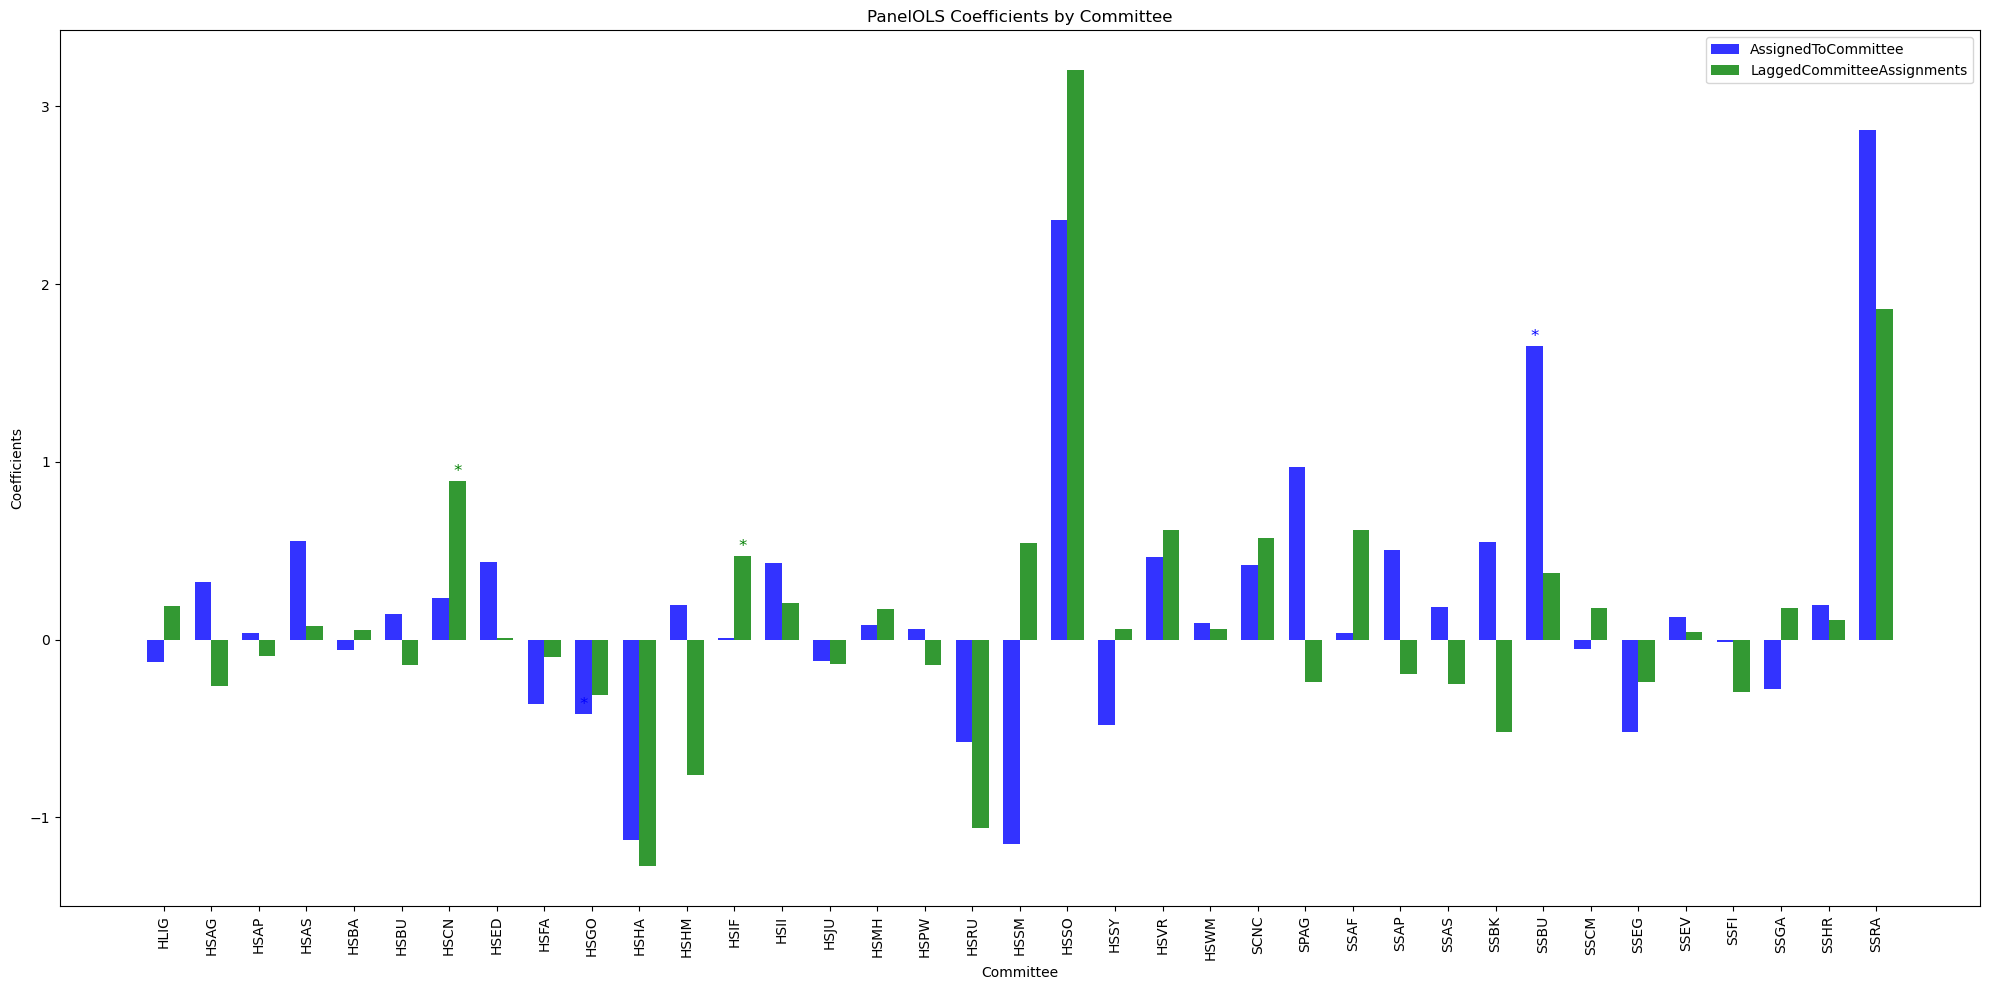

In [91]:
coefficients_df = coefficients_df.sort_values(by='committee').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(coefficients_df.index, coefficients_df['assigned_coeff'], bar_width,
                 alpha=opacity, color='b', label='AssignedToCommittee')

rects2 = plt.bar(coefficients_df.index + bar_width, coefficients_df['lagged_coeff'], bar_width,
                 alpha=opacity, color='g', label='LaggedCommitteeAssignments')

plt.xlabel('Committee')
plt.ylabel('Coefficients')
plt.title('PanelOLS Coefficients by Committee')
plt.xticks(coefficients_df.index, coefficients_df['committee'], rotation=90)
ax.set_xticks(coefficients_df.index + bar_width / 2)
ax.set_xticklabels(coefficients_df['committee'])
plt.legend()
plt.tight_layout()

for i, row in coefficients_df.iterrows():
    if row['assigned_pvalue'] < 0.05:
        ax.text(i, row['assigned_coeff'] + 0.01, '*', ha='center', va='bottom', fontsize=12, color='b')
    if row['lagged_pvalue'] < 0.05:
        ax.text(i + bar_width, row['lagged_coeff'] + 0.01, '*', ha='center', va='bottom', fontsize=12, color='g')

plt.show()


In [94]:
df.columns

Index(['Aggregate', 'HHAH', 'HLCQ', 'HLET', 'HLIG', 'HLOC', 'HSAG', 'HSAP',
       'HSAS', 'HSAT', 'HSBA', 'HSBU', 'HSCN', 'HSDT', 'HSED', 'HSEF', 'HSFA',
       'HSGO', 'HSGW', 'HSHA', 'HSHM', 'HSIF', 'HSII', 'HSIJ', 'HSJU', 'HSMH',
       'HSMM', 'HSPO', 'HSPW', 'HSRU', 'HSSM', 'HSSO', 'HSSY', 'HSUA', 'HSVC',
       'HSVR', 'HSWM', 'HTDE', 'SCNC', 'SLET', 'SLIA', 'SLIN', 'SLPO', 'SPAG',
       'SPIM', 'SPOC', 'SPWW', 'SSAE', 'SSAF', 'SSAP', 'SSAS', 'SSBK', 'SSBU',
       'SSCM', 'SSDT', 'SSEG', 'SSEV', 'SSFI', 'SSFR', 'SSGA', 'SSHR', 'SSJU',
       'SSPO', 'SSRA', 'SSSB', 'SSVA', 'AssignedToCommittee',
       'LaggedCommitteeAssignments'],
      dtype='object', name='committee')

In [95]:
df.index

MultiIndex([('A000076', 116),
            ('A000076', 117),
            ('A000364', 116),
            ('A000367', 115),
            ('A000367', 116),
            ('A000373', 114),
            ('B000574', 115),
            ('B000574', 116),
            ('B000574', 117),
            ('B000589', 113),
            ...
            ('W000804', 115),
            ('W000804', 116),
            ('W000804', 117),
            ('W000816', 114),
            ('Y000062', 114),
            ('Y000062', 115),
            ('Y000062', 116),
            ('Y000062', 117),
            ('Y000063', 114),
            ('Y000063', 115)],
           names=['senator', 'congress'], length=339)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Aggregate   R-squared:                        0.0029
Estimator:                   PanelOLS   R-squared (Between):             -0.0709
No. Observations:                 235   R-squared (Within):              -0.0115
Date:                Wed, Mar 29 2023   R-squared (Overall):             -0.0783
Time:                        19:19:59   Log-likelihood                   -8.5896
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.1390
Entities:                         133   P-value                           0.8704
Avg Obs:                       1.7669   Distribution:                    F(2,96)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             0.1390
                            

/Users/syyun/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
